In [15]:
import sys
import logging
from pathlib import Path

In [8]:
import jax
import jax.numpy as np
import numpy as onp
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

In [9]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.patches import ConnectionPatch

import seaborn as sns

In [29]:
from jax.config import config
config.update("jax_enable_x64", True)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
width = 8

In [11]:
%reload_ext autoreload
%autoreload 2
from fuzzylli.density import SteadyStateCylinder
from fuzzylli.units import set_schroedinger_units as set_units
from fuzzylli.potential import AxialSymmetricPotential, E_c
from fuzzylli.df import ConstantAnisotropyDistribution
from fuzzylli.domain import UniformHypercube
from fuzzylli.io_utils import load_or_compute_model
from fuzzylli.eigenstates import init_eigenstate_library, eigenstate_library
from fuzzylli.interpolation_jax import eval_interp1d as evaluate_spline
from fuzzylli.parameters_from_ellipsoidal_collapse import cylinder_scale_radius_physical_Mpc, cylinder_sqrt_v_dispersion_physical_kms
import fuzzylli.wavefunction as psi
from fuzzylli.cosmology import h


DEBUG:fuzzylli.units:Code units L = 20.362 Kpc, T=21.145 Gyr, M=333999.329 Msun
DEBUG:fuzzylli.units:Code units L = 0.000 Kpc, T=0.000 Gyr, M=0.000 Msun
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


/opt/homebrew/Caskroom/miniforge/base/envs/interference2/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [34]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):

    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

In [17]:
data_dir ="../data"
cache_dir =f"{data_dir}/cache"
Path(cache_dir).mkdir(parents=True, exist_ok=True)

## Load/Compute Wavefunction Parameters

In [21]:
V = {}
rho = {}
df = {}
wavefunction_params = {}
eigenstate_lib = {}
units = {}

M_cylinder = 5e9 #Msun
for m22 in [1.0, 2.0, 4.0]:
    units[m22] = set_units(m22)
    u = units[m22]
    Rmin = .1 * u.from_Kpc
    Rmax = 1 * u.from_Mpc
    seed=42
    N=2**13
    z = 4.0
    a = 1./(1+z)
    units[m22] = u

    df_params = {"R_min": Rmin, "epochs": 6000}
    for beta in [0.0]:
        # BG density
        params_rho_steady_state = {
            "scalefactor": a,
            "r0": h**-1 * cylinder_scale_radius_physical_Mpc(M_cylinder, beta) * u.from_Mpc,
            "sigma2": (cylinder_sqrt_v_dispersion_physical_kms(M_cylinder, beta) * u.from_kms)**2,
        }    
        params_rho_steady_state["beta"] = beta
        rho[(m22,beta)] = SteadyStateCylinder(**params_rho_steady_state)

        #Gravitational Potential
        V[(m22,beta)] = AxialSymmetricPotential(lambda R: rho[(m22,beta)](R)/a, rho[(m22,beta)].R999)

        # Phase Space Distribution
        df[(m22,beta)] = ConstantAnisotropyDistribution(params_rho_steady_state["beta"], a, V[(m22,beta)], rho[(m22,beta)], 
                                                       **df_params, R_max=rho[(m22,beta)].R999)
        kwargs = {
            "for_name":[a,V[(m22,beta)],rho[(m22,beta)].R99,N], 
            "for_compute":[a,V[(m22,beta)],rho[(m22,beta)].R99,N]
        }

        # Initial Eigenstate Library
        eigenstate_lib[(m22,beta)] = load_or_compute_model(
                                        True,
                                        cache_dir,
                                        eigenstate_library.compute_name,
                                        init_eigenstate_library, 
                                        **kwargs)
        
        kwargs = {
            "for_name":[eigenstate_lib[(m22,beta)], rho[(m22,beta)], rho[(m22,beta)].R99, seed], 
            "for_compute":[eigenstate_lib[(m22,beta)], rho[(m22,beta)], df[(m22,beta)], rho[(m22,beta)].R99,seed]
        }

        # Wavefunction Fit
        wavefunction_params[(m22,beta)] = load_or_compute_model(
                                            True,
                                            cache_dir,
                                            psi.wavefunction_params.compute_name,
                                            psi.init_wavefunction_params_least_square,
                                            **kwargs)

DEBUG:fuzzylli.units:Code units L = 20.362 Kpc, T=21.145 Gyr, M=333999.329 Msun
INFO:fuzzylli.potential:dV/dR_max = 0.295
INFO:fuzzylli.potential:Rmin = 0.000, Rmax = 42.890
INFO:fuzzylli.potential:Using N = 250 interpolation points
INFO:fuzzylli.potential:Asymptotic exponenets of rho: alpha = -0.000, beta =3.991
INFO:fuzzylli.mlp:Initial loss: 4486.795106229056
INFO:fuzzylli.mlp:Final loss: 0.3268919305589538
INFO:fuzzylli.io_utils:Model already computed. Load 4756bca70e5007ebd97818e908362ffb...
INFO:fuzzylli.io_utils:Model already computed. Load e08bf9e3c4ed4f975a880e78feadba25...
DEBUG:fuzzylli.units:Code units L = 14.398 Kpc, T=21.145 Gyr, M=118086.595 Msun
INFO:fuzzylli.potential:dV/dR_max = 0.325
INFO:fuzzylli.potential:Rmin = 0.000, Rmax = 60.655
INFO:fuzzylli.potential:Using N = 256 interpolation points
INFO:fuzzylli.potential:Asymptotic exponenets of rho: alpha = -0.000, beta =3.991
INFO:fuzzylli.mlp:Initial loss: 4978.7767273063355
INFO:fuzzylli.mlp:Final loss: 0.085945325398

## Density from Phasespace Distribution

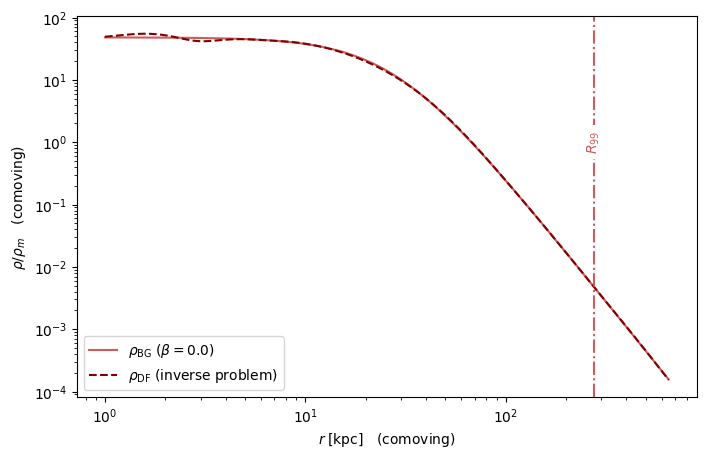

In [30]:
m22 = 2.0
u = units[m22]
betas = [0.0]

x_min = 1 * u.from_Kpc
x_max = 650 * u.from_Kpc
R = np.logspace(np.log10(x_min), np.log10(x_max), 1000)

fig, ax = plt.subplots(figsize=(width,width * 0.618))
ax.set_xscale("log")
ax.set_yscale("log")

c = [("indianred","maroon"),("orange","darkgoldenrod")]
for beta, color in zip(betas, c):
    rho_beta = rho[(m22, beta)]
    df_beta = df[(m22, beta)]

    light_c, dark_c = color
    line, = ax.plot(R * u.to_Kpc, rho_beta(R), label=rf"$\rho_\mathrm{{BG}} \;(\beta = {beta})$", c=light_c)
    ax.plot(R * u.to_Kpc, df_beta.rho(R), ls="dashed", c=dark_c, label=r"$\rho_\mathrm{DF}\; \mathrm{(inverse\;problem)}$")
    ax.axvline(x=rho_beta.R99 * u.to_Kpc, c=light_c, ls="-.")
    ax.text(rho_beta.R99 * u.to_Kpc,1, r'$R_{99}$',rotation=90, ha="center", va="center", color=light_c, 
            bbox=dict(facecolor='w', edgecolor="None"))

ax.legend(*ax.get_legend_handles_labels())
ax.set_xlabel(r"$r\; \mathrm{[kpc]\quad (comoving)}$")
ax.set_ylabel(r"$\rho/\rho_m \quad \mathrm{(comoving)}$")

plt.show()

## Eigenstate Library

/tmp/ipykernel_91850/3477161449.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(labels)


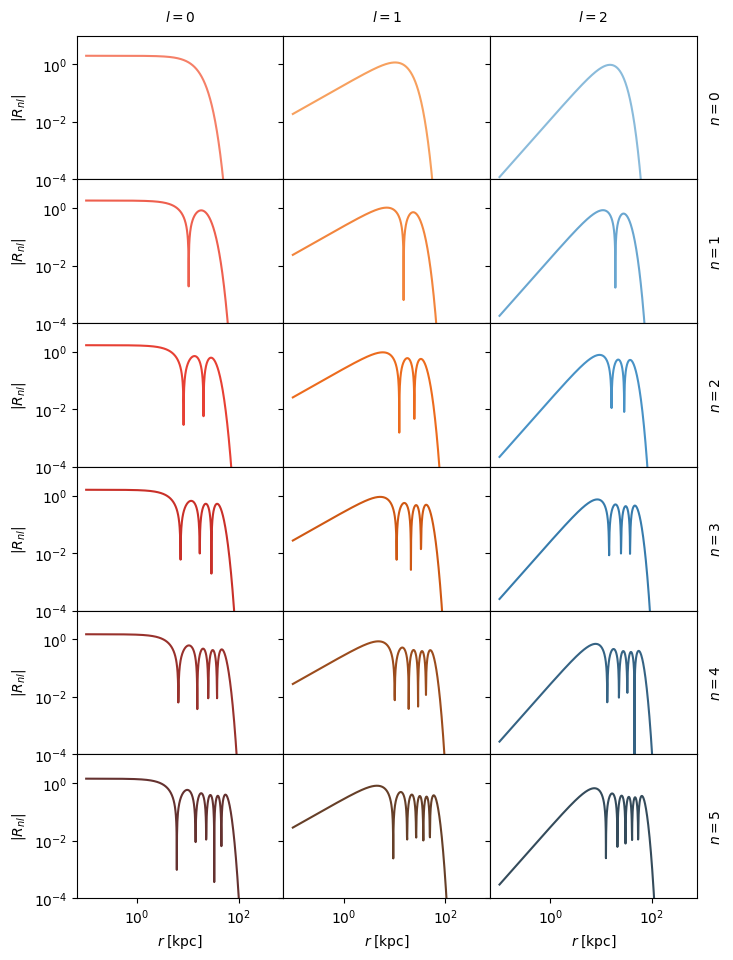

In [31]:
m22 = 2.0
beta=0.0
u = units[m22]

Rmin = .1 * u.from_Kpc
Rmax = 500 * u.from_Kpc
R = np.logspace(np.log10(Rmin), np.log10(Rmax), 1000)
fig, ax = plt.subplots(nrows=6, ncols=3, sharex=True, sharey=True,figsize=(width,1.4*width))

for a in ax.flatten():
    a.set_yscale("log")
    a.set_xscale("log")
    a.set_ylim([1e-4,10])

ns = np.arange(6)
ls = np.arange(3)
cs = sns.color_palette("Reds_d", 6) + sns.color_palette("Oranges_d", 6) + sns.color_palette("Blues_d", 6)

evaluate = jax.vmap(jax.vmap(evaluate_spline, in_axes=(0,None)), in_axes=(None, 0))

R_j_R = evaluate(R, eigenstate_lib[(m22, beta)].R_j_params)
for l in ls:
    for n in ns:
        j = eigenstate_lib[(m22, beta)].j_of_nl(n,l)
        ax[n,l].plot(R * u.to_Kpc, np.abs(R_j_R[j,:]), c=cs[n + l*6])
        
plt.draw()

for a in ax[:,0]:
    a.set_ylabel(r"$|R_{nl}|$")
    
for a in ax[-1,:]:
    labels = a.get_xticklabels()
    labels[1] = ""
    a.set_xticklabels(labels)
    
for a in ax[-1,:]:
    a.set_xlabel(r"$r\; \mathrm{[kpc]}$")
    
for l,a in enumerate(ax[0,:]):
    a.text(0.5, 1.1, rf"$l={l}$", ha="center", transform=a.transAxes)

for n,a in enumerate(ax[:,-1]):
    a.text(1.06, .5, rf"$n={n}$", va="center", transform=a.transAxes, rotation=90)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Wavefunction Fit Result

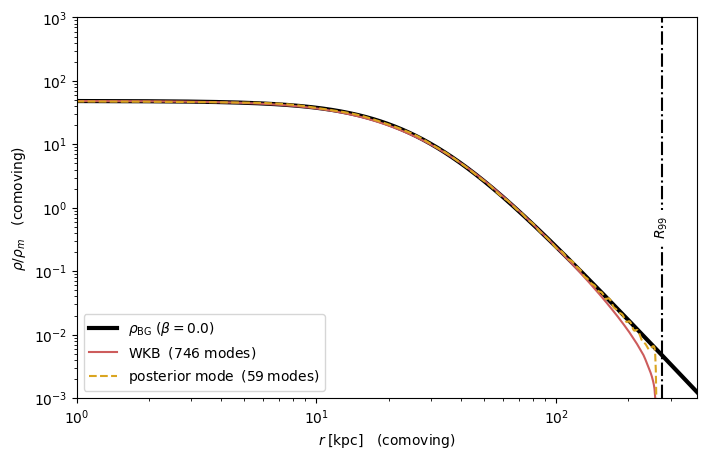

In [32]:
m22 = 2.0
beta = 0.0
u = units[m22]

Rmin = 1 * u.from_Kpc
Rmax = 500 * u.from_Kpc
R = np.logspace(np.log10(Rmin), np.log10(Rmax), 1000)

fig, ax = plt.subplots(figsize=(width,width * 0.618))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1e-3,2000])
    
evaluate = jax.vmap(jax.vmap(evaluate_spline, in_axes=(0,None)), in_axes=(None, 0))

a_j2_WKB = df[(m22,beta)](eigenstate_lib[(m22,beta)].E_j, psi.L(eigenstate_lib[(m22,beta)].l_of_j)) * (2*np.pi)**2
a_j2_WKB /= rho[(m22,beta)].total_mass

wavefunction_params_DF = psi.wavefunction_params(
        total_mass=rho[(m22,beta)].total_mass, 
        R_fit=wavefunction_params[(m22,beta)].R_fit, 
        a_j = np.sqrt(a_j2_WKB), 
        phase_j = 0,
        eigenstate_library=eigenstate_lib[(m22,beta)]
)
rho_psi = jax.vmap(psi.rho, in_axes=(0,None))
c=["black", "indianred", "goldenrod"]

ax.plot(R * u.to_Kpc, rho[(m22,beta)](R), label=rf"$\rho_\mathrm{{BG}} \;(\beta = {beta})$", c=c[0],lw=3)
ax.plot(R * u.to_Kpc, rho_psi(R, wavefunction_params_DF), label=rf"$\mathrm{{WKB}} \;\; ({eigenstate_lib[(m22,beta)].J}\;\mathrm{{modes}})$", c=c[1])
ax.plot(R * u.to_Kpc, rho_psi(R, wavefunction_params[(m22,beta)]), label=rf"$\mathrm{{posterior\;mode}} \;\; ({wavefunction_params[(m22,beta)].eigenstate_library.J} \;\mathrm{{modes}})$", c=c[2], ls="dashed")
ax.axvline(x=rho[(m22,beta)].R99 * u.to_Kpc, c="k", ls="-.")
ax.set_ylabel(r"$\rho/\rho_m \quad \mathrm{(comoving)}$")
ax.set_xlim([Rmin * u.to_Kpc, 1.4*rho[(m22,beta)].R99 * u.to_Kpc])
ax.set_ylim([1e-3, 1000])
ax.text(rho[(m22,beta)].R99 * u.to_Kpc,0.5, r'$R_{99}$',rotation=90, 
        ha="center", va="center", color="k", 
        bbox=dict(facecolor='w', edgecolor="None"))
ax.legend(*ax.get_legend_handles_labels(), loc="lower left")
    
ax.set_xlabel(r"$r\; \mathrm{[kpc]\quad (comoving)}$")
plt.show()

## Filament Cross Sections

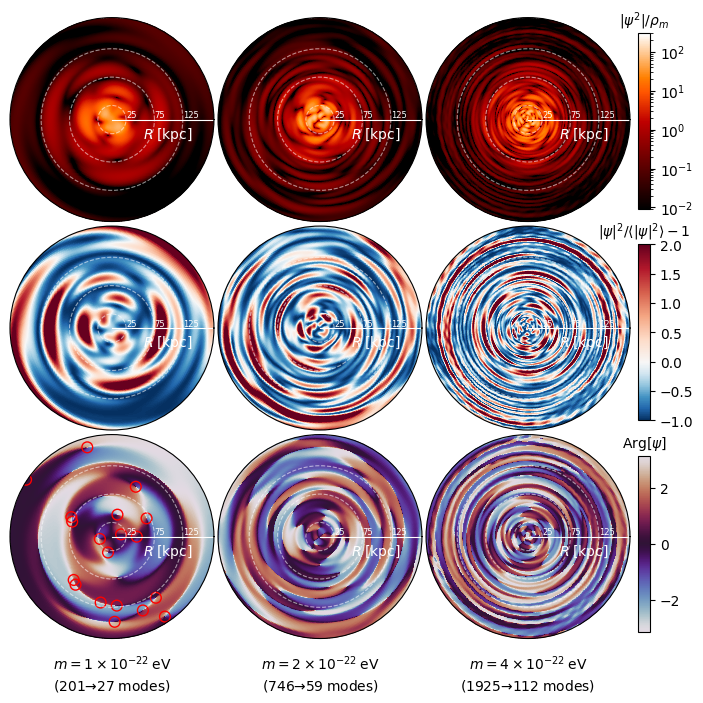

In [37]:
beta = 0.0
t =[ 0 * u.from_Myr]
fig, axss = plt.subplots(ncols=3, nrows=3, figsize=(width, 1.1*width),subplot_kw=dict(projection='polar'))

cmap1 = shiftedColorMap(matplotlib.colormaps['gist_heat'], midpoint=0.5)
cmap2 = shiftedColorMap(matplotlib.colormaps['RdBu_r'], midpoint=0.33)
cmap3 = shiftedColorMap(matplotlib.colormaps['twilight'], midpoint=0.5)

for axs, m22 in zip(axss.T, [1.0, 2.0, 4.0]):
    u = units[m22]
    Rmin = .1 * u.from_Kpc
    Rmax = 200 * u.from_Kpc 
    R_phi_domain = UniformHypercube([500,500],np.array([[Rmin, 1.0* Rmax],[0,2*np.pi]]))
    Rphi = R_phi_domain.cell_centers_meshgrid
    R, phi = R_phi_domain.cell_centers_cartesian[:,0], R_phi_domain.cell_centers_cartesian[:,1]
    domain = R_phi_domain
    
    _psi = jax.vmap(lambda R, phi: psi.psi(R, phi, t[0], wavefunction_params[(m22,beta)]), in_axes=(0,0))
    _vorticity = jax.vmap(lambda R, phi: psi.vorticity(R, phi, t[0], wavefunction_params[(m22,beta)]), in_axes=(0,0))
    rho_static = jax.vmap(lambda R: psi.rho(R, wavefunction_params[(m22,beta)]), in_axes=0)

    psi_Rphit = _psi(R,phi).reshape(domain.N)
    rho_Rphit = np.abs(psi_Rphit)**2
    rho_static_Rphi = rho_static(R).reshape(domain.N)
    
    im = axs[0].pcolormesh(Rphi[1], Rphi[0] * u.to_Kpc, rho_Rphit, norm=colors.LogNorm(vmin=9e-3, vmax=3e2), cmap=cmap1, rasterized=True)
    im2 = axs[1].pcolormesh(Rphi[1], Rphi[0] * u.to_Kpc, rho_Rphit/rho_static_Rphi-1, vmin=-1, vmax=2, cmap=cmap2, rasterized=True)
    im3 = axs[2].pcolormesh(Rphi[1], Rphi[0] * u.to_Kpc, np.angle(psi_Rphit), vmin=-np.pi, vmax=np.pi, cmap=cmap3, rasterized=True)
    axs[2].text(0.5, -0.15, rf"$m = {latex_float(m22 * 1e-22)}\; \mathrm{{ eV}}$", transform=axs[2].transAxes, ha="center")
    axs[2].text(0.5, -0.25, rf"$({eigenstate_lib[(m22,beta)].J} \to {wavefunction_params[(m22,beta)].eigenstate_library.J}\; \mathrm{{modes}})$", transform=axs[2].transAxes, ha="center")
    if m22 < 2.0:
        omega = _vorticity(R, phi).reshape(domain.N)
        omega_1d=gaussian_filter(np.abs(omega), 1, mode='nearest').flatten()
        mean = np.mean(omega_1d)
        omega_1d_mean = onp.array(omega_1d/mean)
        peaks = peaks = find_peaks(omega_1d_mean, height=10, distance=10*domain.N[1])[0]
        peak_idx = np.unravel_index(peaks, domain.N)
        R, phi = domain.cell_centers
        axs[2].scatter(phi[peak_idx[1]], R[peak_idx[0]] * u.to_Kpc, s=60, facecolors='none', edgecolors='r')
        
    for ax in axs:
        ax.set_rlim(Rmin * u.to_Kpc, 0.9*Rmax * u.to_Kpc)
        rtick_loc = [25, 75, 125]
    
        ax.set_rticks(rtick_loc)
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.grid(axis="y", ls="dashed")

        #Phi direction
        ax.set_xticklabels([])
        ax.set_xticks([0.0], minor=False)

        # R direction
        ax.text(0.65, .41, r"$R\; \mathrm{ [kpc]}$", transform=ax.transAxes, zorder=10, c="white")
        ax.set_rlabel_position(0)
    
        
        ax.yaxis.label.set_color('white')
        ax.tick_params(axis='y', colors='white')

        ax.grid(color="white")
        ax.grid(axis="y", ls="dashed", alpha=0.55)
    
cax = fig.add_axes([0.91, .63, 0.015, .2])
cb = fig.colorbar(im,orientation="vertical",cax=cax)
cax.text(.5, 1.05, r"$|\psi^2|/\rho_m$", transform=cax.transAxes, ha="center")

cax2 = fig.add_axes([.91, 0.39, .015, 0.2])
cb2 = fig.colorbar(im2,orientation="vertical",cax=cax2)
cax2.xaxis.set_label_position('top') 
cax2.xaxis.tick_top()
cax2.text(.5, 1.05, r"$|\psi|^2/\langle |\psi|^2 \rangle - 1$", transform=cax2.transAxes, ha="center")

cax3 = fig.add_axes([.91, 0.15, .015, 0.2])
cb3 = fig.colorbar(im3,orientation="vertical",cax=cax3)
cax3.xaxis.set_label_position('top') 
cax3.xaxis.tick_top()
cax3.text(.5, 1.05, r"$\mathrm{Arg}[\psi]$", transform=cax3.transAxes, ha="center")

fig.subplots_adjust(wspace=0.02, hspace=-0.2)
plt.show()